ToggleButtons(description='Metric: ', index=1, options=('Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve'), value='Accuracy')

HBox(children=(Select(description='Of Task: ', index=3, options=('Both Tasks', 'Sentence Transcription', 'Q&A Conversation', 'Between Tasks'), value='Between Tasks'), Select(description='Of Subject: ', index=2, options=('All Subjects', '#1', '#2', '#3', 'Between Subjects'), value='#2')))

<IPython.core.display.Javascript object>


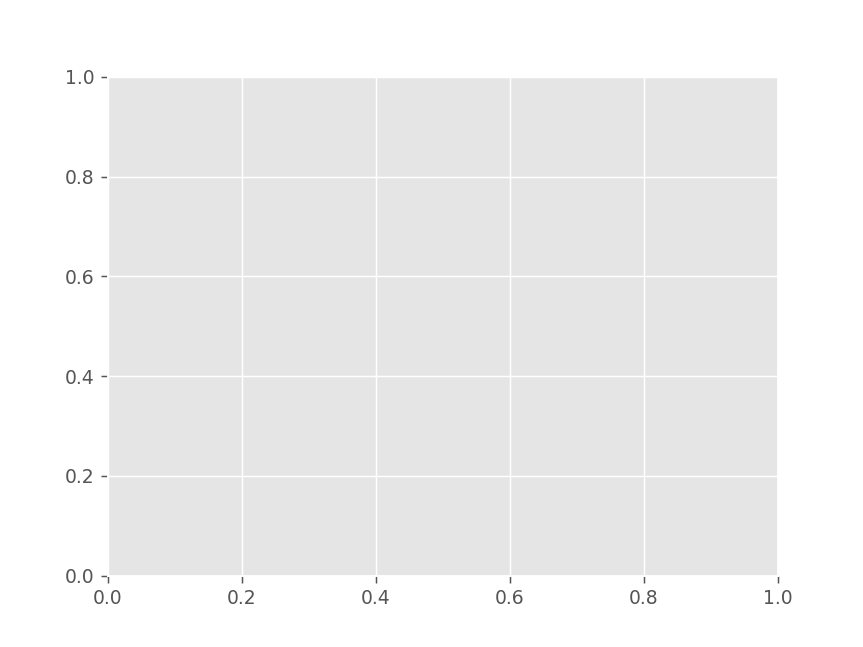

In [68]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np

class Sentence:
	# class variables here
	def __init__(self, subject, task, sentenceNo, testing):
		# instance variables here
		self.subject = subject
		self.task = task			# 0: transcribe; 1: free conversation
		self.sentenceNo = sentenceNo
		self.testing = testing		# 0: practice; 1: test
		self.keyboard = 0			# 0: win EyeControl; 1: tobii WinControl
		self.wpm = 0.0
		self.totErrRate = 0.0

def readSentences(argFilename, argSentences):
	with open('RawData/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			if 'Transcribe' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 0, int(row[0]), int(row[1])))
			elif 'FreeConv' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 1, int(row[0]), 1))
			# exclude exceptions that the test subject didn't enter anything and skipped this sentence			
			if int(row[2]) != 0:
				sentences[-1].wpm = int(row[4])+int(row[5])*0.1**(len(row[5]))
				sentences[-1].totErrRate = int(row[-14])*0.1**(len(row[-14]))
			else:
				sentences[-1].wpm = 0
				sentences[-1].totErrRate = 1
			if 'winEyeControl' in argFilename:
				sentences[-1].keyboard = 0
			elif 'tobiiWinControl' in argFilename:
				sentences[-1].keyboard = 1				

def onChange_metric(b):
	if b['type']=='change' and b['name']=='value':
		clearCache()
		extractSentences()

def onChange_task(change):
	if change['type']=='change' and change['name']=='value':
		clearCache()
		extractSentences()

def onChange_subject(change):
	if change['type']=='change' and change['name']=='value':
		clearCache()
		extractSentences()

def extractSentences():
	for item in sentences:
		if item.testing == 1:
			if ('1' in contrOfSubject.value and item.subject == 0) or ('2' in contrOfSubject.value and item.subject == 1) or ('3' in contrOfSubject.value and item.subject == 2):
				if ('Transcription' in contrOfTask.value and item.task == 0) or ('Conversation' in contrOfTask.value and item.task == 1):
					perSubjTaskWpm[(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.wpm)
					perSubjTaskTotErrRate[(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.totErrRate)
					perSubjTaskSentenceNo[(int(contrOfSubject.value[1])-1)*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.sentenceNo)
			elif ('All' in contrOfSubject.value) or ('Between' in contrOfSubject.value):
				if ('Transcription' in contrOfTask.value and item.task == 0) or ('Conversation' in contrOfTask.value and item.task == 1) or ('Both' in contrOfTask.value) or ('Between' in contrOfTask.value):
					perSubjTaskWpm[item.subject*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.wpm)
					perSubjTaskTotErrRate[item.subject*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.totErrRate)
					perSubjTaskSentenceNo[item.subject*amountTask*amountKeyboard+item.task*amountKeyboard + item.keyboard].append(item.sentenceNo)

	if 'Speed' in contrMetric.value:
		plotSpeed()
	elif 'Accuracy' in contrMetric.value:
		plotAccuracy()
	elif 'Learning' in contrMetric.value:
		plotLearningCurve()

def clearCache():
	clear_output(wait=True)
	display(contrMetric, widgets.HBox([contrOfTask, contrOfSubject]))
	for i in range(amountSubject * amountTask * amountKeyboard):
		del perSubjTaskWpm[i][:], perSubjTaskTotErrRate[i][:], perSubjTaskSentenceNo[i][:]

def plotSpeed():
	fig, ax = plt.subplots()
	if 'Between' not in contrOfSubject.value:
		yWpm_MS, yWpm_Tobii = ([] for k in range(2))
		for i in range(len(perSubjTaskWpm)):
			for j in range(len(perSubjTaskWpm[i])):
				if i%amountKeyboard:
					yWpm_MS.append(perSubjTaskWpm[i][j])
				else:
					yWpm_Tobii.append(perSubjTaskWpm[i][j])
		bp_MS = plt.boxplot(yWpm_MS, positions=[1], showfliers=True, showmeans=True, labels=['MS'], patch_artist=True,
							boxprops=dict(facecolor=color[0]),
							meanprops=dict(markerfacecolor='white', markeredgecolor='white'),
							medianprops=dict(linewidth=0, linestyle=None))
		bp_Tobii = plt.boxplot(yWpm_Tobii, positions=[2], showfliers=True, showmeans=True, labels=['Tobii'], patch_artist=True,
							boxprops=dict(facecolor=color[1]),
							meanprops=dict(markerfacecolor='white', markeredgecolor='white'),
							medianprops=dict(linewidth=0, linestyle=None))

		ax.set(title=contrOfSubject.value+' speed during '+contrOfTask.value, ylabel='WPM')
		plt.xlim(0,3)	
		plt.ylim(-1,18)	
		plt.xticks([1,2], ('Windows\nEye Control','Tobii\nWindows Control'))
		fig.savefig('plotSpeed_'+contrOfSubject.value+'_'+contrOfTask.value+'.png', bbox_inches='tight')

def plotAccuracy():
	fig, ax = plt.subplots()
	if ('Between' not in contrOfSubject.value) and ('Transcription' in contrOfTask.value):
		yTotErrRate_MS, yTotErrRate_Tobii = ([] for k in range(2))
		for i in range(len(perSubjTaskTotErrRate)):
			for j in range(len(perSubjTaskTotErrRate[i])):
				if i%amountKeyboard:
					yTotErrRate_MS.append(perSubjTaskTotErrRate[i][j])
				else:
					yTotErrRate_Tobii.append(perSubjTaskTotErrRate[i][j])
		bp_MS = plt.boxplot(yTotErrRate_MS, positions=[1], showfliers=True, showmeans=True, labels=['MS'], patch_artist=True,
							boxprops=dict(facecolor=color[0]),
							meanprops=dict(markerfacecolor='white', markeredgecolor='white'),
							medianprops=dict(linewidth=0, linestyle=None))
		bp_Tobii = plt.boxplot(yTotErrRate_Tobii, positions=[2], showfliers=True, showmeans=True, labels=['Tobii'], patch_artist=True,
							boxprops=dict(facecolor=color[1]),
							meanprops=dict(markerfacecolor='white', markeredgecolor='white'),
							medianprops=dict(linewidth=0, linestyle=None))

		ax.set(title=contrOfSubject.value+' Accuracy during '+contrOfTask.value, ylabel='WPM')
		plt.xlim(0,3)	
		plt.ylim(-0.05,1)	
		plt.xticks([1,2], ('Windows\nEye Control','Tobii\nWindows Control'))
		fig.savefig('plotAccuracy_'+contrOfSubject.value+'_'+contrOfTask.value+'.png', bbox_inches='tight')


def plotLearningCurve():
	pass

if __name__ == "__main__":
	sentences = []	
	amountSubject = 3
	amountTask = 2
	amountKeyboard = 2
	color = ['gray', '#01ac66']		# dynavox green
	labelKeybd = ['win10 Eye Control', 'tobii Windows Control']

	perSubjTaskWpm, perSubjTaskTotErrRate, perSubjTaskSentenceNo = ([[] for i in range(amountSubject * amountTask * amountKeyboard)] for j in range(3))	

	# readSentences()
	filenames = ['1Greta_s1Transcribe_winEyeControl', '1Greta_s2Transcribe_tobiiWinControl', '2Carlota_s1Transcribe_winEyeControl', '2Carlota_s2FreeConv_winEyeControl', '2Carlota_s3Transcribe_tobiiWinControl',
				'2Carlota_s4FreeConv_tobiiWinControl', '3Barbara_s1Transcribe_tobiiWinControl', '3Barbara_s2FreeConv_tobiiWinControl', '3Barbara_s3Transcribe_winEyeControl', '3Barbara_s4FreeConv_winEyeControl']
	for item in filenames:
		readSentences(item, sentences)

	# define UI controls
	contrMetric = widgets.ToggleButtons(
		options=['Speed', 'Accuracy', 'Speed & Accuracy', 'Learning Curve'],
		description = 'Metric: ',
		value = 'Speed',
		disabled = False
		)
	contrOfTask = widgets.Select(
		options = ['Both Tasks', 'Sentence Transcription', 'Q&A Conversation', 'Between Tasks'],
		description = 'Of Task: ',
		value = 'Sentence Transcription',
		disabled = False
		)
	contrOfSubject = widgets.Select(
		options = ['All Subjects', '#1', '#2', '#3', 'Between Subjects'],
		description = 'Of Subject: ',
		value = '#2',
		disabled = False
		)
	display(contrMetric, widgets.HBox([contrOfTask, contrOfSubject]))
	contrMetric.observe(onChange_metric)
	contrOfTask.observe(onChange_task)
	contrOfSubject.observe(onChange_subject)

In [ ]:
[[] for i in range (3 * 2)]